In [339]:
import xarray as xr
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask

dask.config.set(**{'array.slicing.split_large_chunks': True})

Setting up the parameters for analysis
- ystart = start year of hindcasts
- yend = end year of hindcasts
- domain = domain being considered
- freq = time frequency being considered
- var = CESM variable being considered
- topdir = the base directory of the SMYLE data
- expname = the experiment name

In [326]:
ystart = 1958 ; yend = 1997 ; nyears=yend-ystart+1
domain = "atm" ; freq = "day_1" ; var = "PSL"
initmon = 11
nmems = 10
memstr = [str(i).zfill(3) for i in np.arange(1,nmems+1,1)]
topdir="/glade/campaign/cesm/development/espwg/SMYLE/archive/"
expname="b.e21.BSMYLE.f09_g17"

Set up longitudes and latitudes of Reykjavik and the Azores

In [233]:
# NAO station index longitudes and latitudes
reyklon = 360.-21.9426 ; reyklat = 64.1466
azorelon = 360.-25.6687 ; azorelat = 25.6687

In [234]:
# uncomment if you want to shut down the cluster
#client.close()
#cluster.close()

Set up the dask cluster

In [235]:
# get the workers going
ncores = 1
nworkers = 10
nmem="5GB"
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
cores = ncores, processes = ncores, project="P04010022", walltime="04:00:00")
cluster.scale(nworkers)
client = Client(cluster)

In [236]:
# do this until you see you've got some workers
client

Client Scheduler: tcp://10.12.205.200:35098 Dashboard: http://10.12.205.200/proxy/8787/status,Cluster Workers: 10 Cores: 10 Memory: 250.00 GB


Sorting out the SMYLE data into an NAO index array of the form (init_year, member, time)

In [ ]:
for iyear in np.arange(ystart,yend+1,1):
    filelist = [glob.glob(topdir+expname+"."+str(iyear)+"-"+str(initmon)+"."+imem+"/"+domain+"/proc/tseries/"+freq+"/*."+var+".*")[0] for imem in memstr]
    print(iyear)
    dat = xr.open_mfdataset(filelist, combine='nested', concat_dim='M')
    
    # calculate time_bnds average to fix the CESM calendar
    timebndavg = np.array(dat.time_bnds.isel(M=0),
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    
    # manually fix the average of time bounds at 02/29-03/01 for leap years
    dates = pd.DatetimeIndex(timebndavg)
    lyindices = np.argwhere( (dates.month == 2) & (dates.day == 29))
    if (len(lyindices) > 0):
        for i in lyindices:
            timebndavg[i] = str(dates.year[i].item())+"-02-28T12:00:00"
    
    dat['time'] = timebndavg 
    
    # dropping the first time value which will have hour == 00
    dat = dat.where( dat.time.dt.hour == 12, drop=True)
    
    # --- check ensemble size
    if (dat.M.size != nmems):
        print("You do not have "+str(nmems)+" members for year "+str(iyear)+" aborting...")
        sys.exit()
        
    # --- check for consistent size of time dimension
    if (iyear > ystart) and (dat.time.size != nao_smyle.time.size):
        print('the size of "time" in year '+str(iyear)+' does not match that of year '+str(ystart)+'. Aborting...')
        sys.exit()
            
    # grab out the Reykjavik and Azores location
    reykpsltemp = dat.sel(lon=reyklon, lat=reyklat, method="nearest")
    azorepsltemp = dat.sel(lon=azorelon, lat=azorelat, method="nearest") 
    
    # set up output arrays
    if (iyear == ystart):
        ntime = reykpsltemp.time.size
        nao_smyle = xr.DataArray(np.zeros([nyears,nmems,ntime]), 
                                 coords = [np.arange(ystart,yend+1,1), np.arange(1,10+1,1), dat.time], dims=['init_year','member','time'], name='nao_smyle')
     
    # Fill NAO output array
    nao_smyle[iyear-ystart,:,:] = np.array(reykpsltemp.PSL) - np.array(azorepsltemp.PSL)

Sort out the ERA5 data into an NAO index array of the form (init_year, time)

In [ ]:
# Sort out ERA5 data
topdir="/glade/scratch/islas/processed/era5/SLP_day/"
dat = xr.open_mfdataset(topdir+"*.nc").sel(time=slice("1950-01-01","2020-12-31"))

# pick out start and end dates for the smyle hindcasts and calculate the number of years used
starttime = nao_smyle.time.isel(time=0) ; endtime = nao_smyle.time.isel(time=ntime-1)
nyearshc = (endtime.dt.year - starttime.dt.year).values

# loop through years and fill the ERA5 NAO array
for iyear in np.arange(ystart,yend+1,1):
    print(iyear)
    starttime_era = str(iyear)+"-"+str(starttime.dt.month.values).zfill(2)+"-"+str(starttime.dt.day.values).zfill(2)
    endtime_era = str(iyear+nyearshc)+"-"+str(endtime.dt.month.values).zfill(2)+"-"+str(endtime.dt.day.values).zfill(2)
    datuse = dat.sel(time=slice(starttime_era, endtime_era))
 
    # Remove Feb 29th.
    datuse = datuse.sel(time=~((datuse.time.dt.month==2) & (datuse.time.dt.day == 29)))

    # grab out the Reykjavik and Azores location
    reykpsltemp = datuse.sel(lon=reyklon, lat=reyklat, method="nearest")
    azorepsltemp = datuse.sel(lon=azorelon, lat=azorelat, method="nearest") 

    # initialize NAO array
    if (iyear == ystart):
        ntime = nao_smyle.time.size
        nao_era5 = xr.DataArray(np.zeros([nyears,ntime]),
                               coords=[np.arange(ystart,yend+1,1), datuse.time],
                               dims=['init_year','time'], name='nao_era5')
        
    # Fill NAO array
    nao_era5[iyear-ystart,:] = np.array(reykpsltemp.slp) - np.array(azorepsltemp.slp)

Plotting the NAO index on day 1

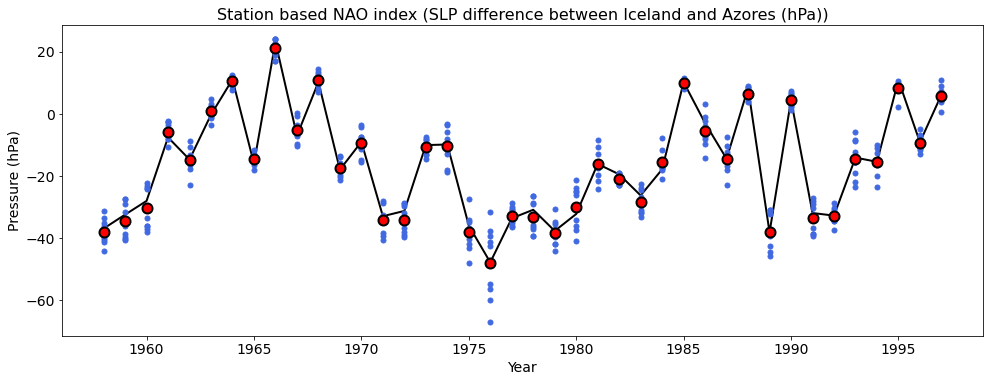

In [373]:
# plot day 1 
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'

ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.plot(nao_era5.init_year,nao_era5.isel(time=0)/100., linewidth=2, color='black', label="ERA5")
ax.set_title('Station based NAO index (SLP difference between Iceland and Azores (hPa))', fontsize=16)
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Year')
nao_smyle_em = nao_smyle.mean(dim="member").isel(time=0)/100.
nao_smyle_members = nao_smyle.isel(time=0)/100.

for imem in nao_smyle_members.member:
    ax.plot(nao_smyle_members.init_year, nao_smyle_members.sel(member=imem),"o", markersize=5, markerfacecolor='royalblue', markeredgecolor='royalblue')
ax.plot(nao_smyle_em.init_year,nao_smyle_em,"o", markersize=10, markerfacecolor='red',markeredgecolor='black', markeredgewidth=2)


Calculate the correlation between SMYLE and ERA5 NAO (note that no deseasonalizing has been done here)

In [388]:
ccoef = np.zeros([nao_smyle_em.time.size])
for i in np.arange(0,nao_smyle_em.time.size,1):
    ccoef[i] = xr.corr(nao_smyle_em.isel(time=i), nao_era5.isel(time=i))
    

Plot the correlation between SMYLE and ERA5 as a function of lead time

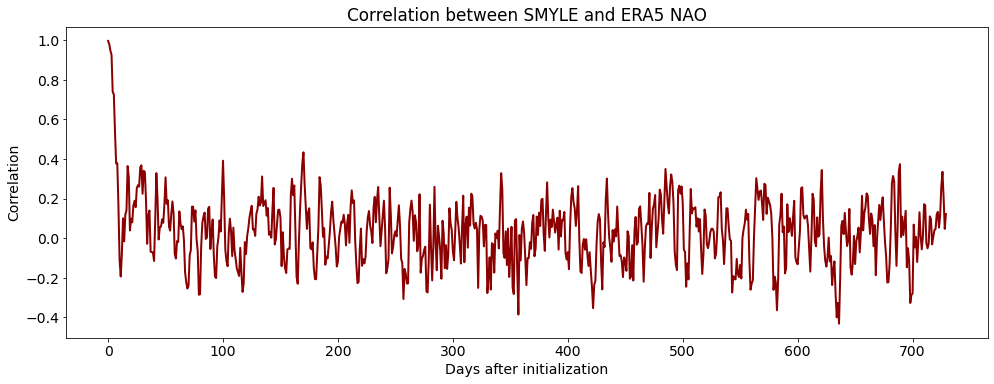

In [391]:
# plot correlation
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'

ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Days after initialization')
ax.set_title('Correlation between SMYLE and ERA5 NAO')
ax.plot(np.arange(0,nao_smyle_em.time.size,1),ccoef, color='darkred', linewidth=2)